In [20]:
import os
import glob
import cv2
import pandas as pd

import torch

import matplotlib.pyplot as plt
%matplotlib inline

from libs.dali_helper import (J2kIterator, j2k_decode_pipeline, j2k_postprocessing, JllIterator, 
                         jll_process_pipeline, jll_postprocessing, CustomDALIGenericIterator)
from libs.image_processing import to_3_channels, get_yolo, roi_extraction_yolov5, show_img_and_roi, crop_img, resize_and_pad, check_mkdir

os.environ["CUDA_VISIBLE_DEVICES"] = '0'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
IMG_DIR = "/home/data4/share/rsna-breast-cancer-detection/train_images"

df = pd.read_csv("/home/data4/share/rsna-breast-cancer-detection/train.csv")
df['dcm'] = IMG_DIR + '/' + df.patient_id.astype(str) + '/' + df.image_id.astype(str) + '.dcm'
df_j2k, df_jll = df[df["site_id"]==2].reset_index(drop=True), df[df["site_id"]==1].reset_index(drop=True)
print('j2k:', len(df_j2k), 'jll:', len(df_jll))

j2k: 25187 jll: 29519


In [9]:
rsna_768_images = glob.glob("../rsna_768_png/*.png")
rsna_768_images

['../rsna_768_png/10038_1350492010.png',
 '../rsna_768_png/10006_462822612.png',
 '../rsna_768_png/10006_1874946579.png',
 '../rsna_768_png/10006_1459541791.png',
 '../rsna_768_png/10038_850559196.png',
 '../rsna_768_png/10006_1864590858.png',
 '../rsna_768_png/10038_1967300488.png',
 '../rsna_768_png/10038_2142944869.png']

## J2k Decoding Pipeline Example

In [10]:
j2k_it = J2kIterator(df=df[df["patient_id"]==10006], batch_size=4, img_dir=IMG_DIR)

In [11]:
j2k_pipe = j2k_decode_pipeline(j2k_it, width=768, height=768, batch_size=4, num_threads=2, device_id=0, 
                             py_num_workers=1, exec_async=False, exec_pipelined=False)
j2k_pipe.build()

In [12]:
%%time
j2k_out = j2k_pipe.run()

CPU times: user 589 ms, sys: 374 ms, total: 963 ms
Wall time: 955 ms


In [13]:
img, img_window = j2k_postprocessing(j2k_out, 0)

#### j2k images

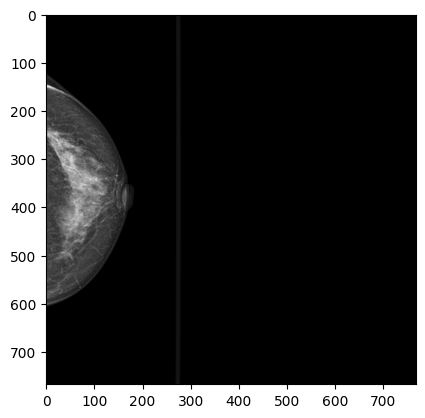

In [16]:
plt.imshow(img_window, cmap='bone')
plt.show()

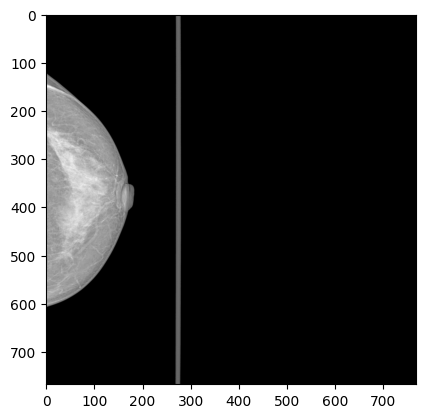

In [17]:
plt.imshow(img, cmap='bone')
plt.show()

In [21]:
%%time
png_img = cv2.imread(rsna_768_images[1])

CPU times: user 5.57 ms, sys: 1.53 ms, total: 7.1 ms
Wall time: 6.04 ms


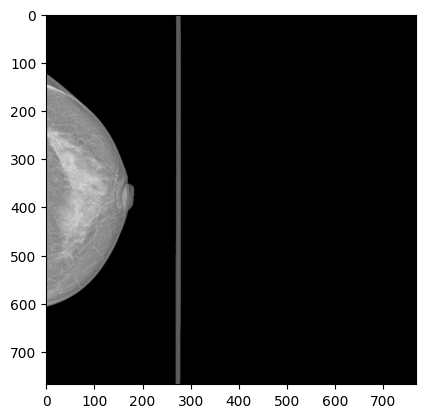

In [22]:
png_img = cv2.imread(rsna_768_images[1])
plt.imshow(png_img, cmap='bone')
plt.show()

## Jll Processing Pipeline

In [24]:
jll_it = JllIterator(df=df[df["patient_id"]==10038], batch_size=4, img_dir=IMG_DIR)

In [25]:
jll_pipe = jll_process_pipeline(jll_it, width=768, height=768, batch_size=4, num_threads=2, device_id=0, 
                              py_num_workers=1, exec_async=False, exec_pipelined=False)
jll_pipe.build()
jll_out = jll_pipe.run()

In [26]:
img, img_window = jll_postprocessing(jll_out, 0)

#### jll images

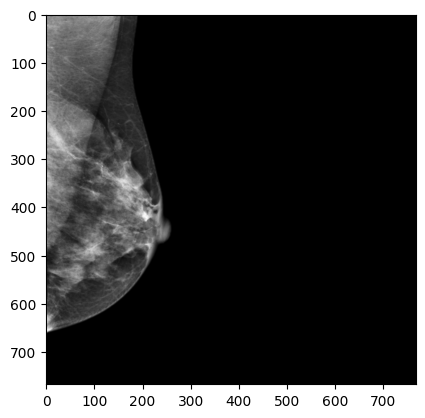

In [27]:
plt.imshow(img_window, cmap='bone')
plt.show()

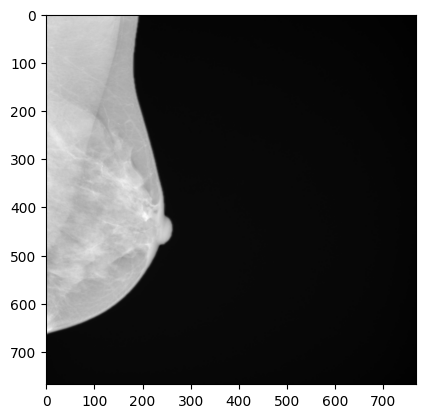

In [28]:
plt.imshow(img, cmap='bone')
plt.show()

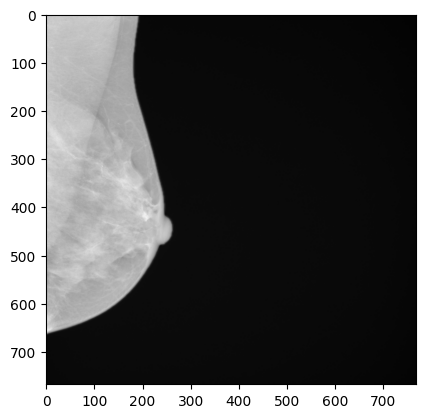

In [29]:
png_img = cv2.imread(rsna_768_images[6])
plt.imshow(png_img, cmap='bone')
plt.show()

## Decode of lossless jpg is not currenly supported by nvjpeg on gpu!!!

In [ ]:
class JpgIterator(object):
    
    def __init__(self, df, batch_size, img_dir):
        self.df = df
        self.batch_size = batch_size
        self.img_dir = img_dir

    @staticmethod
    def dicom_to_jpg(img_dir, patient_id, image_id):
        dcmfile = pydicom.dcmread(f'{img_dir}/{patient_id}/{image_id}.dcm')
        
        if dcmfile.file_meta.TransferSyntaxUID == '1.2.840.10008.1.2.4.70':
            with open(f'{img_dir}/{patient_id}/{image_id}.dcm', 'rb') as fp:
                raw = DicomBytesIO(fp.read())
                ds = pydicom.dcmread(raw)
            offset = ds.PixelData.find(b"\xff\xd8\xff\xe0")

            return np.frombuffer(ds.PixelData[offset:], dtype=np.uint8), dcmfile.PhotometricInterpretation == 'MONOCHROME1'

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __iter__(self):
        self.i = 0
        return self

    def __next__(self):
        if self.i > len(self.df):
            raise StopIteration

        compressed_imgs, is_monochrome_imgs = [], []
        patient_ids, img_ids = [], []

        batch_start, batch_finish = self.i, min(self.i + self.batch_size, len(self.df))
        df_batch = self.df.iloc[range(batch_start, batch_finish)]

        for patient_id, img_id in df_batch[["patient_id", "image_id"]].values:
            compressed_img, is_monochrome_img = self.dicom_to_jpg(self.img_dir, patient_id, img_id)

            compressed_imgs.append(compressed_img)
            is_monochrome_imgs.append(np.array([is_monochrome_img], dtype = np.bool_))

            patient_ids.append(np.array([patient_id], dtype = np.int64))
            img_ids.append(np.array([img_id], dtype = np.int64))

        self.i += self.batch_size

        return compressed_imgs, is_monochrome_imgs, patient_ids, img_ids

In [ ]:
JpgIter = JpgIterator(df=df_train.iloc[[0]], batch_size=1, img_dir=train_img_dir)

In [ ]:
@pipeline_def
def jpeg_decode_pipeline():
    imgs, is_monochromes, p_ids, i_ids = fn.external_source(
        source=JpgIter, num_outputs=4, device="cpu", dtype=[types.UINT8, types.BOOL, types.INT64, types.INT64]
    )

    imgs = fn.experimental.decoders.image(
        imgs, device='mixed', output_type=types.ANY_DATA, dtype=DALIDataType.UINT16
    )
    
    return imgs, is_monochromes, p_ids, i_ids

In [ ]:
pipe = jpeg_decode_pipeline(batch_size=1, num_threads=1, device_id=0, 
                           py_num_workers=1, exec_async=False, exec_pipelined=False)
pipe.build()
out = pipe.run()